In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, '/home/jupyter/')
from hourly_pollution_prediction.process_and_join.bbox import * 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#for image inpainting
from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
import cv2 as cv
import xesmf as xe
import geopandas as gpd
import rioxarray
from rioxarray.merge import merge_arrays
from pathlib import Path

lake_charles_no2= xr.open_dataset(f'lakecharles_no2.nc', engine='netcdf4')
lafayette_no2= xr.open_dataset(f'lafayette_no2.nc', engine='netcdf4')
lake_charles_o3= xr.open_dataset(f'lakecharles_o3.nc', engine='netcdf4')
lafayette_o3= xr.open_dataset(f'lafayette_o3.nc', engine='netcdf4')

In [9]:
lake_charles_no2_df = lake_charles_no2.mean(dim=['latitude','longitude'], keep_attrs=True)
lake_charles_no2_df = lake_charles_no2_df[['vertical_column_troposphere']].to_dataframe().reset_index()
lake_charles_no2_df.rename(columns={'vertical_column_troposphere':'no2_lakecharles'}, inplace=True)

lafayette_no2_df = lafayette_no2.mean(dim=['latitude','longitude'], keep_attrs=True)
lafayette_no2_df = lafayette_no2_df[['vertical_column_troposphere']].to_dataframe().reset_index()
lafayette_no2_df.rename(columns={'vertical_column_troposphere':'no2_lafayette'}, inplace=True)

lake_charles_o3_df = lake_charles_o3.mean(dim=['latitude','longitude'], keep_attrs=True)
lake_charles_o3_df = lake_charles_o3_df[['column_amount_o3']].to_dataframe().reset_index()
lake_charles_o3_df.rename(columns={'column_amount_o3':'o3_lakecharles'}, inplace=True)

lafayette_o3_df = lafayette_o3.mean(dim=['latitude','longitude'], keep_attrs=True)
lafayette_o3_df = lafayette_o3_df[['column_amount_o3']].to_dataframe().reset_index()
lafayette_o3_df.rename(columns={'column_amount_o3':'o3_lafayette'}, inplace=True)


In [11]:
no2_df = pd.merge(lake_charles_no2_df, lafayette_no2_df, on='time')
o3_df = pd.merge(lafayette_o3_df, lake_charles_o3_df, on='time')


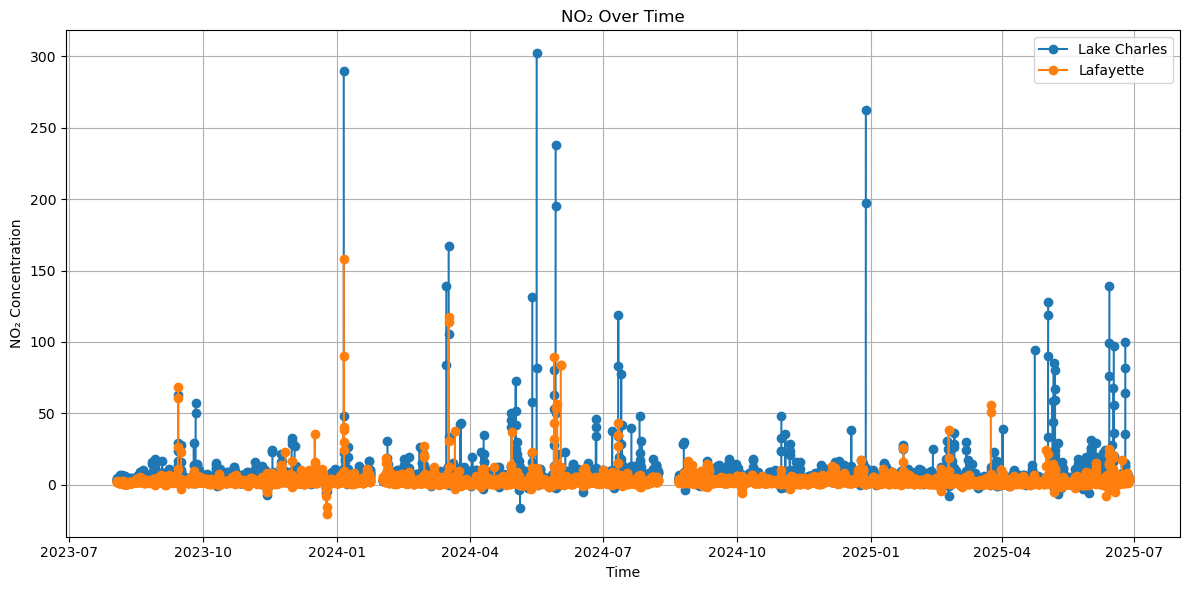

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert time column to datetime
no2_df['time'] = pd.to_datetime(no2_df['time'])
plt.figure(figsize=(12, 6))
plt.plot(no2_df['time'], no2_df['no2_lakecharles'], label='Lake Charles', marker='o')
plt.plot(no2_df['time'], no2_df['no2_lafayette'], label='Lafayette', marker='o')
plt.xlabel('Time')
plt.ylabel('NO₂ Concentration')
plt.title('NO₂ Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


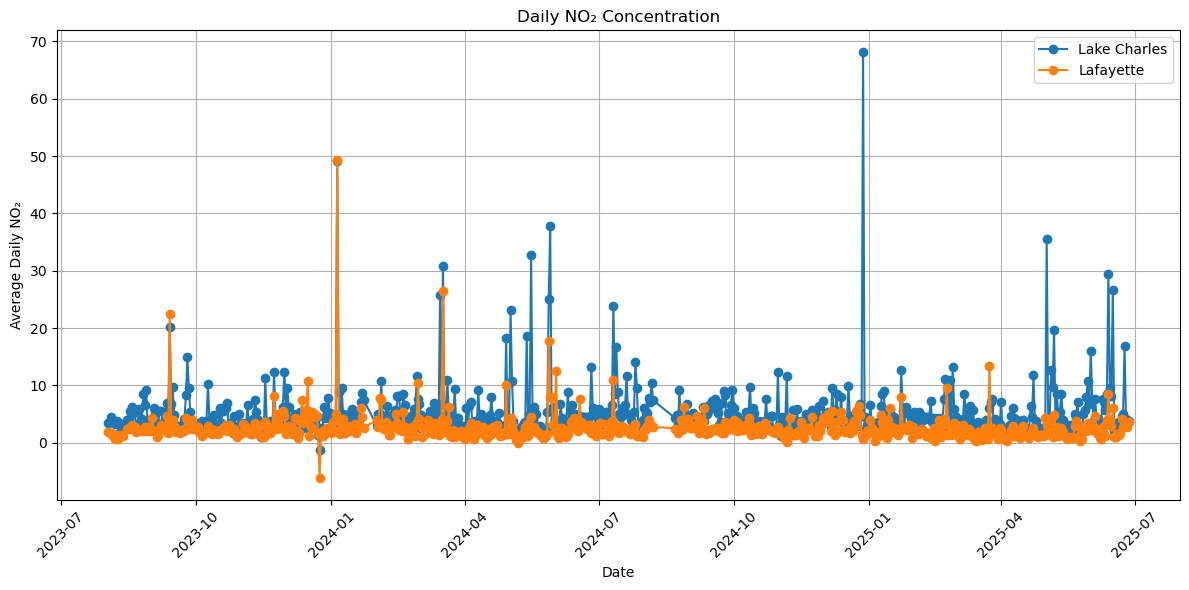

In [13]:
no2_daily = no2_df.groupby(no2_df['time'].dt.date).agg({
    'no2_lakecharles': 'mean',
    'no2_lafayette': 'mean'
}).reset_index()
no2_daily.rename(columns={'time': 'date'}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(no2_daily['date'], no2_daily['no2_lakecharles'], label='Lake Charles', marker='o')
plt.plot(no2_daily['date'], no2_daily['no2_lafayette'], label='Lafayette', marker='o')
plt.xlabel('Date')
plt.ylabel('Average Daily NO₂')
plt.title('Daily NO₂ Concentration')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


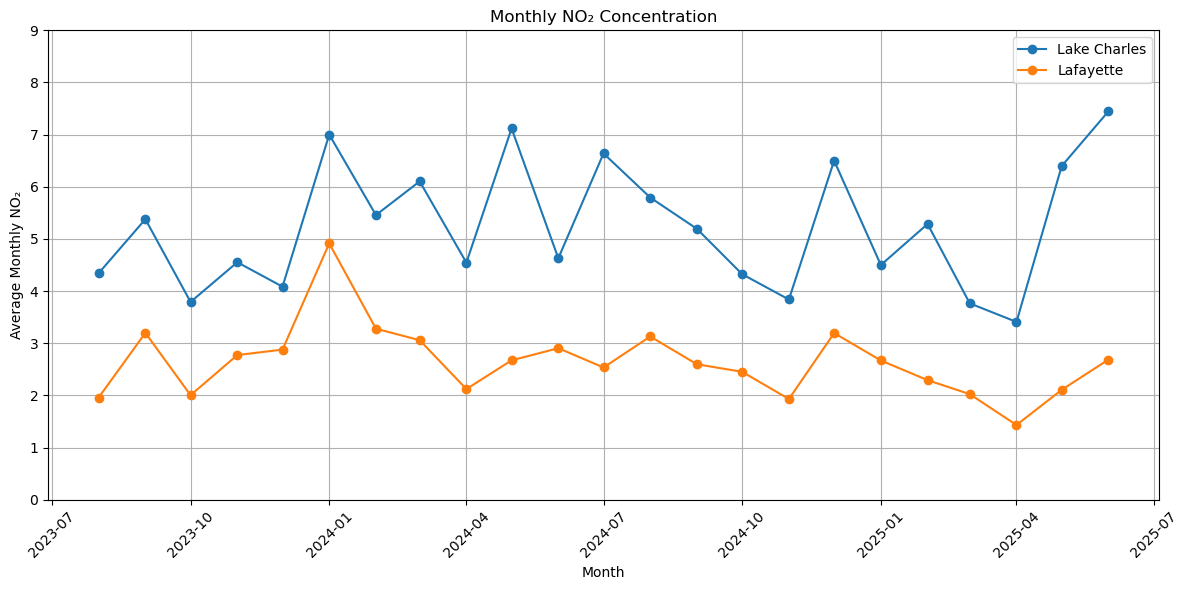

In [18]:
no2_monthly = no2_df.groupby(no2_df['time'].dt.to_period('M')).agg({
    'no2_lakecharles': 'mean',
    'no2_lafayette': 'mean'
}).reset_index()
no2_monthly['time'] = no2_monthly['time'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(no2_monthly['time'], no2_monthly['no2_lakecharles'], label='Lake Charles', marker='o')
plt.plot(no2_monthly['time'], no2_monthly['no2_lafayette'], label='Lafayette', marker='o')
plt.xlabel('Month')
plt.ylabel('Average Monthly NO₂')
plt.title('Monthly NO₂ Concentration')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.ylim(0,9)
plt.show()


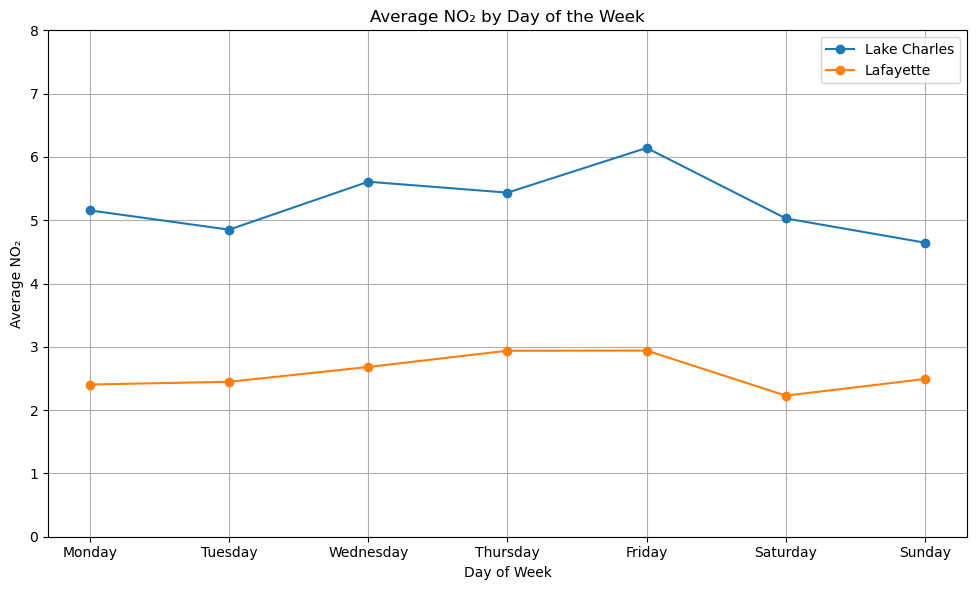

In [19]:
no2_df['weekday'] = no2_df['time'].dt.day_name()

no2_weekday = no2_df.groupby('weekday').agg({
    'no2_lakecharles': 'mean',
    'no2_lafayette': 'mean'
}).reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(no2_weekday['weekday'], no2_weekday['no2_lakecharles'], label='Lake Charles', marker='o')
plt.plot(no2_weekday['weekday'], no2_weekday['no2_lafayette'], label='Lafayette', marker='o')
plt.xlabel('Day of Week')
plt.ylabel('Average NO₂')
plt.title('Average NO₂ by Day of the Week')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0,8)
plt.show()


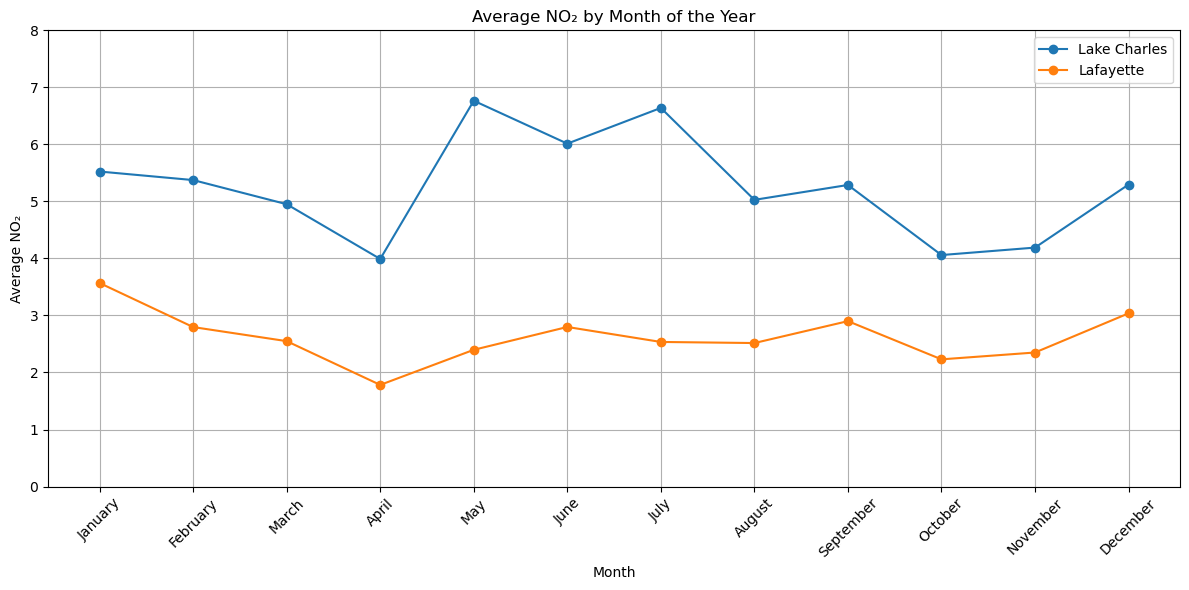

In [21]:
no2_df['month'] = no2_df['time'].dt.month_name()

no2_monthofyear = no2_df.groupby('month').agg({
    'no2_lakecharles': 'mean',
    'no2_lafayette': 'mean'
}).reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(no2_monthofyear['month'], no2_monthofyear['no2_lakecharles'], label='Lake Charles', marker='o')
plt.plot(no2_monthofyear['month'], no2_monthofyear['no2_lafayette'], label='Lafayette', marker='o')
plt.xlabel('Month')
plt.ylabel('Average NO₂')
plt.title('Average NO₂ by Month of the Year')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.ylim(0,8)
plt.show()


In [23]:
no2_df.groupby('hour').count()

,time,no2_lakecharles,no2_lafayette,weekday,month
hour,,,,,
2,1,1,1,1,1
4,14,8,8,14,14
5,69,16,16,69,69
6,605,68,67,605,605
7,1106,315,336,1106,1106
8,993,845,859,993,993
9,669,660,660,669,669
10,635,632,633,635,635
11,623,616,611,623,623


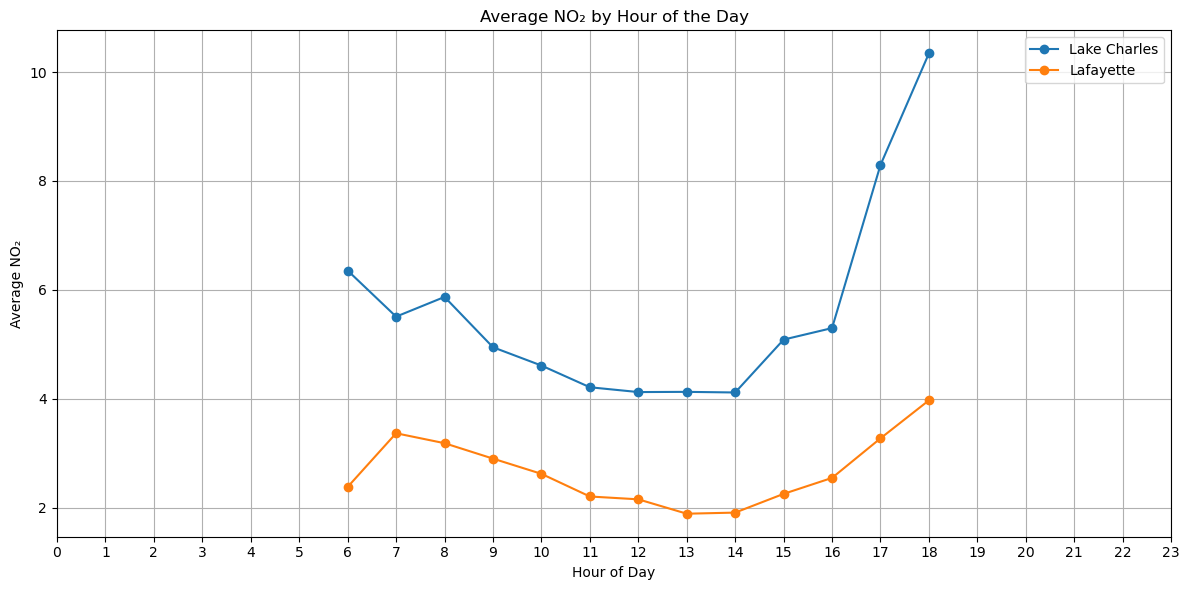

In [24]:
# Extract hour from timestamp
no2_df['hour'] = no2_df['time'].dt.hour

# Group by hour and calculate mean
no2_hourly = no2_df.groupby('hour').agg({
    'no2_lakecharles': 'mean',
    'no2_lafayette': 'mean'
}).reset_index()
no2_hourly=no2_hourly[(no2_hourly['hour']>5) & (no2_hourly['hour']<19)]
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(no2_hourly['hour'], no2_hourly['no2_lakecharles'], label='Lake Charles', marker='o')
plt.plot(no2_hourly['hour'], no2_hourly['no2_lafayette'], label='Lafayette', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average NO₂')
plt.title('Average NO₂ by Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
